In [ ]:
# --- Cell 1: Setup & engine -----------------------------------------------
# Purpose: load environment variables, create an SQLAlchemy engine,
# and ensure output folders exist.

import os
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

warnings.filterwarnings("ignore")  # keep notebook output tidy
load_dotenv()

# Project paths (relative to notebook location)
PROJ_ROOT = Path("..").resolve()
DATA_DIR = PROJ_ROOT / "data"
STAGING_DIR = DATA_DIR / "staging"
PROCESSED_DIR = DATA_DIR / "processed"
REPORTS_DIR = PROJ_ROOT / "reports"
FIG_DIR = REPORTS_DIR / "figures"

for p in [STAGING_DIR, PROCESSED_DIR, FIG_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# Read DB credentials from .env (fail fast if missing)
USER = os.getenv("MYSQL_USER")
PWD  = os.getenv("MYSQL_PASSWORD")
HOST = os.getenv("MYSQL_HOST", "localhost")
PORT = os.getenv("MYSQL_PORT", "3306")
DB   = os.getenv("MYSQL_DB", "nz_rent")

assert USER and PWD and HOST and PORT and DB, "Missing DB env vars; check your .env."

# Use mysql-connector-python driver
engine = create_engine(
    f"mysql+mysqlconnector://{USER}:{PWD}@{HOST}:{PORT}/{DB}",
    pool_pre_ping=True,  # avoid stale connections
)

# Sanity check: print the active database
with engine.connect() as conn:
    print("Connected DB:", conn.exec_driver_sql("SELECT DATABASE();").scalar())


Connected DB: nz_rent


In [59]:
# --- Cell 2: Load staging table -------------------------------------------
# Purpose: create the staging table if needed, truncate it,
# read CSV, basic de-duplication & type normalisation, and load.

# Define staging DDL (kept minimal; schema lives in sql/00_create_schema.sql)
DDL_STAGING = """
CREATE TABLE IF NOT EXISTS stg_rent (
  date_month DATE,
  suburb_name VARCHAR(128),
  region VARCHAR(128),
  territorial_authority VARCHAR(128),
  property_type VARCHAR(64),
  median_rent DECIMAL(10,2),
  count_bonds INT,
  lat DECIMAL(9,6),
  lon DECIMAL(9,6)
) ENGINE=InnoDB;
"""

with engine.begin() as conn:
    conn.execute(text("USE nz_rent;"))
    conn.execute(text(DDL_STAGING))
    conn.execute(text("TRUNCATE TABLE stg_rent;"))  # idempotent load

# Read CSV
csv_path = STAGING_DIR / "staging_rent.csv"
df = pd.read_csv(csv_path)

# Basic cleaning: parse month as date, trim strings, drop exact duplicates on grain
df["date_month"] = pd.to_datetime(df["date_month"]).dt.date

# String trimming (avoid accidental join mismatches due to whitespace)
for col in ["suburb_name", "region", "territorial_authority", "property_type"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

# Drop duplicates on the analytic grain (month × suburb × type)
df = df.drop_duplicates(subset=["date_month", "suburb_name", "region", "property_type"])

# Load into staging
df.to_sql("stg_rent", con=engine, if_exists="append", index=False, chunksize=10_000)
print("Rows in staging:", pd.read_sql("SELECT COUNT(*) AS cnt FROM stg_rent;", engine).iloc[0, 0])


Rows in staging: 1122


In [60]:
# --- Cell 3: Populate dimensions & fact -----------------------------------
# Purpose: upsert into dimensions and fact using normalised joins.
# Notes:
# - TRIM/NULLIF used in joins to avoid '' vs NULL mismatches.
# - ON DUPLICATE KEY keeps fact idempotent: safe to re-run.

SQL_UPSERT = """
-- dim_time
INSERT INTO dim_time (date_month, year, quarter, month)
SELECT DISTINCT
  date_month,
  YEAR(date_month),
  QUARTER(date_month),
  MONTH(date_month)
FROM stg_rent
WHERE date_month IS NOT NULL
ON DUPLICATE KEY UPDATE date_month = VALUES(date_month);

-- dim_suburb
INSERT INTO dim_suburb (suburb_name, territorial_authority, region, suburb_code, lat, lon)
SELECT DISTINCT
  TRIM(suburb_name),
  NULLIF(TRIM(territorial_authority), ''),
  NULLIF(TRIM(region), ''),
  NULL,
  NULLIF(lat, 0.0),
  NULLIF(lon, 0.0)
FROM stg_rent
WHERE suburb_name IS NOT NULL
ON DUPLICATE KEY UPDATE
  region = VALUES(region),
  territorial_authority = VALUES(territorial_authority);

-- dim_property_type
INSERT INTO dim_property_type (property_type_name)
SELECT DISTINCT TRIM(property_type)
FROM stg_rent
WHERE property_type IS NOT NULL
ON DUPLICATE KEY UPDATE property_type_name = VALUES(property_type_name);

-- fact_rent (idempotent + normalised join)
INSERT INTO fact_rent (time_id, suburb_id, property_type_id, median_rent, count_bonds)
SELECT DISTINCT
  t.time_id,
  s.suburb_id,
  p.property_type_id,
  r.median_rent,
  r.count_bonds
FROM stg_rent r
JOIN dim_time t
  ON t.date_month = r.date_month
JOIN dim_suburb s
  ON s.suburb_name = TRIM(r.suburb_name)
 AND (s.region <=> NULLIF(TRIM(r.region), ''))
JOIN dim_property_type p
  ON p.property_type_name = TRIM(r.property_type)
ON DUPLICATE KEY UPDATE
  median_rent = VALUES(median_rent),
  count_bonds = VALUES(count_bonds);
"""

with engine.begin() as conn:
    for stmt in SQL_UPSERT.split(";"):
        if stmt.strip():
            conn.execute(text(stmt))

# Quick sense-check: expected vs actual rows in fact
qry_expected = """
SELECT COUNT(*) FROM (
  SELECT DISTINCT
    date_month,
    TRIM(suburb_name),
    NULLIF(TRIM(region),''),
    TRIM(property_type)
  FROM stg_rent
) x;
"""
with engine.connect() as conn:
    expected = conn.execute(text(qry_expected)).scalar()
    actual = conn.execute(text("SELECT COUNT(*) FROM fact_rent;")).scalar()
print("Expected distinct combos (month × suburb × type):", expected)
print("Rows in fact_rent:", actual)

Expected distinct combos (month × suburb × type): 1122
Rows in fact_rent: 1122


In [61]:
# --- Cell 4: Regional monthly summary -------------------------------------
# Purpose: aggregate to month × region for top-level charts and CSV export.

Q_REGION = """
SELECT
  t.date_month,
  d.region,
  ROUND(AVG(f.median_rent), 2) AS avg_rent,
  SUM(f.count_bonds) AS total_bonds
FROM fact_rent f
JOIN dim_time t ON f.time_id = t.time_id
JOIN dim_suburb d ON f.suburb_id = d.suburb_id
GROUP BY t.date_month, d.region
ORDER BY t.date_month, d.region;
"""
df_region = pd.read_sql(Q_REGION, engine, parse_dates=["date_month"])
out_csv = PROCESSED_DIR / "region_month_summary.csv"
df_region.to_csv(out_csv, index=False)
df_region.head()


,date_month,region,avg_rent,total_bonds
0,2023-01-01,Auckland,698.00,1398.0
1,2023-01-01,Canterbury/Christchurch,576.11,642.0
2,2023-01-01,Wellington,658.89,638.0
3,2023-02-01,Auckland,702.00,1365.0
4,2023-02-01,Canterbury/Christchurch,583.89,628.0


In [64]:
# --- Cell 5: MoM by suburb × property type --------------------------------
# Purpose: month-over-month change per suburb/type. Avoid divide-by-zero.

Q_MOM = """
WITH base AS (
  SELECT
    d.suburb_name,
    pt.property_type_name,
    t.date_month,
    f.median_rent,
    LAG(f.median_rent) OVER (
      PARTITION BY d.suburb_name, pt.property_type_name
      ORDER BY t.date_month
    ) AS prev_rent
  FROM fact_rent f
  JOIN dim_time t ON f.time_id = t.time_id
  JOIN dim_suburb d ON f.suburb_id = d.suburb_id
  JOIN dim_property_type pt ON f.property_type_id = pt.property_type_id
)
SELECT
  suburb_name,
  property_type_name,
  date_month,
  median_rent,
  prev_rent,
  ROUND((median_rent - prev_rent) / NULLIF(prev_rent, 0) * 100, 2) AS mom_pct
FROM base
ORDER BY suburb_name, property_type_name, date_month;
"""
df_mom = pd.read_sql(Q_MOM, engine, parse_dates=["date_month"])
df_mom.to_csv(PROCESSED_DIR / "suburb_month_rent_change.csv", index=False)
df_mom.head(10)


,suburb_name,property_type_name,date_month,median_rent,prev_rent,mom_pct
0,Addington,1-bedroom,2023-01-01,410.0,NaN,NaN
1,Addington,1-bedroom,2023-02-01,415.0,410.0,1.22
2,Addington,1-bedroom,2023-03-01,410.0,415.0,-1.20
3,Addington,1-bedroom,2023-04-01,415.0,410.0,1.22
4,Addington,1-bedroom,2023-05-01,415.0,415.0,0.00
5,Addington,1-bedroom,2023-06-01,420.0,415.0,1.20
6,Addington,1-bedroom,2023-07-01,415.0,420.0,-1.19
7,Addington,1-bedroom,2023-08-01,405.0,415.0,-2.41
8,Addington,1-bedroom,2023-09-01,415.0,405.0,2.47
9,Addington,1-bedroom,2023-10-01,430.0,415.0,3.61


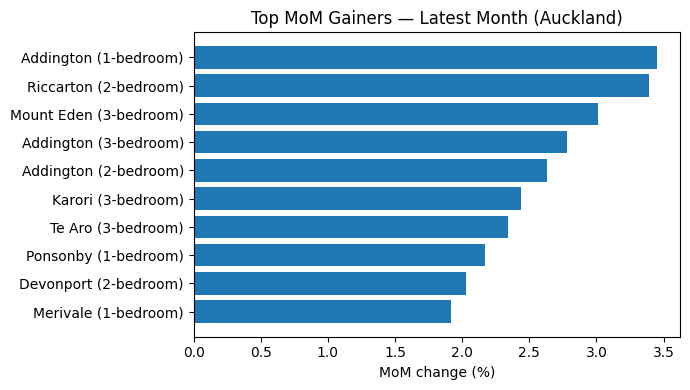

In [65]:
# --- Cell 6: Top MoM gainers at the latest month --------------------------
# Purpose: rank top movers for the latest available month and visualise.

Q_TOP_MOM = """
WITH base AS (
  SELECT
    d.suburb_name,
    pt.property_type_name,
    t.date_month,
    f.median_rent,
    LAG(f.median_rent) OVER (
      PARTITION BY d.suburb_name, pt.property_type_name
      ORDER BY t.date_month
    ) AS prev_rent
  FROM fact_rent f
  JOIN dim_time t ON f.time_id = t.time_id
  JOIN dim_suburb d ON f.suburb_id = d.suburb_id
  JOIN dim_property_type pt ON f.property_type_id = pt.property_type_id
),
latest AS (SELECT MAX(date_month) AS max_month FROM base),
cut AS (
  SELECT b.*
  FROM base b
  JOIN latest l ON b.date_month = l.max_month
  WHERE b.prev_rent IS NOT NULL
)
SELECT
  suburb_name,
  property_type_name,
  date_month,
  median_rent,
  prev_rent,
  ROUND((median_rent - prev_rent) / NULLIF(prev_rent, 0) * 100, 2) AS mom_pct
FROM cut
ORDER BY mom_pct DESC
LIMIT 10;
"""
df_top_mom = pd.read_sql(Q_TOP_MOM, engine, parse_dates=["date_month"])
df_top_mom.to_csv(PROCESSED_DIR / "top_mom_gainers.csv", index=False) 

# Plot
if not df_top_mom.empty:
    plot = df_top_mom.copy()
    plot["label"] = plot["suburb_name"] + " (" + plot["property_type_name"] + ")"
    plot = plot.sort_values("mom_pct", ascending=True)

    plt.figure(figsize=(7, 4))
    plt.barh(plot["label"], plot["mom_pct"])
    plt.title("Top MoM Gainers — Latest Month (Auckland)")
    plt.xlabel("MoM change (%)")
    plt.tight_layout()
    (FIG_DIR / "top_mom_gainers.png").unlink(missing_ok=True)
    plt.savefig(FIG_DIR / "top_mom_gainers.png", dpi=120)
    plt.show()


In [66]:
# --- Cell 7: Rolling 3-month volatility -----------------------------------
# Purpose: short-window volatility suited to short datasets.

Q_VOL3 = """
SELECT
  d.suburb_name,
  pt.property_type_name,
  t.date_month,
  f.median_rent,
  ROUND(
    STDDEV_SAMP(f.median_rent) OVER (
      PARTITION BY d.suburb_name, pt.property_type_name
      ORDER BY t.date_month
      ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
    ), 2
  ) AS rolling3_std
FROM fact_rent f
JOIN dim_time t ON f.time_id = t.time_id
JOIN dim_suburb d ON f.suburb_id = d.suburb_id
JOIN dim_property_type pt ON f.property_type_id = pt.property_type_id
ORDER BY d.suburb_name, pt.property_type_name, t.date_month;
"""
df_vol3 = pd.read_sql(Q_VOL3, engine, parse_dates=["date_month"])
df_vol3.to_csv(PROCESSED_DIR / "suburb_month_rolling3std.csv", index=False)

# Top volatile at the latest month
Q_VOL3_TOP = """
WITH latest AS (SELECT MAX(t.date_month) AS max_month FROM dim_time t),
v AS (
  SELECT
    d.suburb_name, pt.property_type_name, t.date_month,
    ROUND(
      STDDEV_SAMP(f.median_rent) OVER (
        PARTITION BY d.suburb_name, pt.property_type_name
        ORDER BY t.date_month
        ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
      ), 2
    ) AS rolling3_std
  FROM fact_rent f
  JOIN dim_time t ON f.time_id = t.time_id
  JOIN dim_suburb d ON f.suburb_id = d.suburb_id
  JOIN dim_property_type pt ON f.property_type_id = pt.property_type_id
)
SELECT * FROM v
JOIN latest l ON v.date_month = l.max_month
ORDER BY rolling3_std DESC
LIMIT 10;
"""
df_vol3_top = pd.read_sql(Q_VOL3_TOP, engine)
df_vol3_top.to_csv(PROCESSED_DIR / "top_rolling3std.csv", index=False)


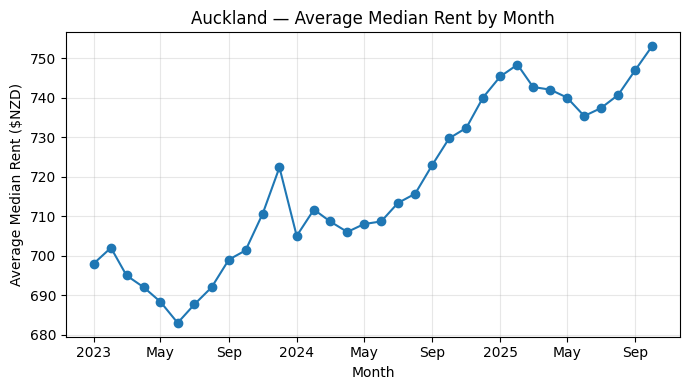

In [67]:
# --- Cell 8: Trendline (Auckland) -----------------------------------------
# Purpose: save a clean timeseries plot suitable for README.

plot_df = (df_region[df_region["region"] == "Auckland"]
           .sort_values("date_month")[["date_month", "avg_rent"]])

plt.figure(figsize=(7, 4))
plt.plot(plot_df["date_month"], plot_df["avg_rent"], marker="o")
plt.title("Auckland — Average Median Rent by Month")
plt.xlabel("Month")
plt.ylabel("Average Median Rent ($NZD)")

# Nice date formatting
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
plt.grid(True, alpha=0.3)
plt.tight_layout()
(FIG_DIR / "trend_auckland.png").unlink(missing_ok=True)
plt.savefig(FIG_DIR / "trend_auckland.png", dpi=120)
plt.show()


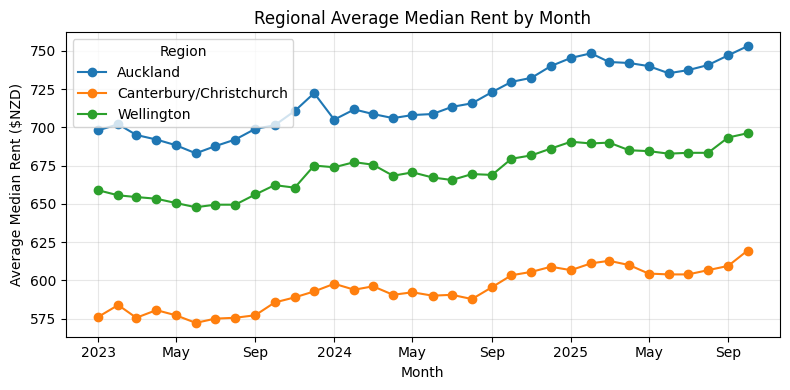

In [ ]:
# --- Regional trend (multi-line) -------------------------------------------
# Purpose: compare month-by-month trends across Auckland, Wellington, Christchurch.

# Ensure df_region exists; if not, fetch from DB
if "df_region" not in globals() or df_region.empty:
    Q_REGION = """
    SELECT
      t.date_month,
      d.region,
      ROUND(AVG(f.median_rent), 2) AS avg_rent
    FROM fact_rent f
    JOIN dim_time t ON f.time_id = t.time_id
    JOIN dim_suburb d ON f.suburb_id = d.suburb_id
    GROUP BY t.date_month, d.region
    ORDER BY t.date_month, d.region;
    """
    df_region = pd.read_sql(Q_REGION, engine, parse_dates=["date_month"])

# Pivot to wide: index = month, columns = region, values = avg_rent
wide = (df_region
        .sort_values("date_month")
        .pivot_table(index="date_month", columns="region", values="avg_rent", aggfunc="mean"))

plt.figure(figsize=(8, 4))
for col in wide.columns:
    plt.plot(wide.index, wide[col], marker="o", label=col)

plt.title("Regional Average Median Rent by Month")
plt.xlabel("Month")
plt.ylabel("Average Median Rent ($NZD)")

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
plt.legend(title="Region")
plt.grid(True, alpha=0.3)
plt.tight_layout()

FIG_DIR = Path("../reports/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)
plt.savefig(FIG_DIR / "regional_trend.png", dpi=120)
plt.show()


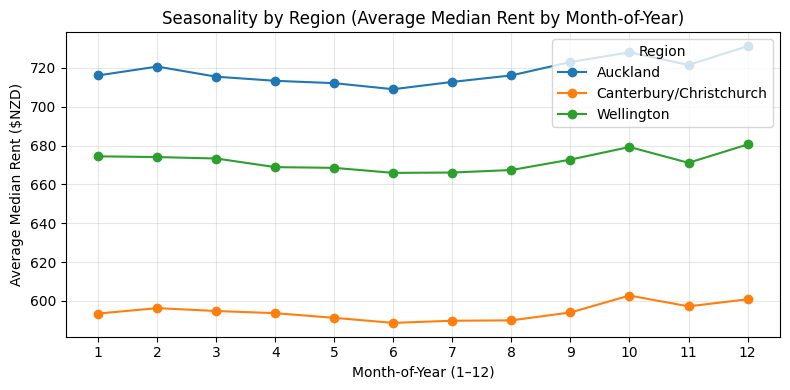

In [ ]:
# --- Seasonality profile (avg by month-of-year) ----------------------------
# Purpose: verify seasonal pattern per region by month-of-year across the dataset.

seasonal = df_region.copy()
seasonal["month"] = seasonal["date_month"].dt.month

# Average across the same month-of-year (if only 2024, it still shows shape)
prof = (seasonal
        .groupby(["region", "month"], as_index=False)["avg_rent"]
        .mean()
        .sort_values(["region", "month"]))

# Plot as multi-line (x = month 1..12)
plt.figure(figsize=(8, 4))
for region, sub in prof.groupby("region"):
    sub = sub.sort_values("month")
    plt.plot(sub["month"], sub["avg_rent"], marker="o", label=region)

plt.title("Seasonality by Region (Average Median Rent by Month-of-Year)")
plt.xlabel("Month-of-Year (1–12)")
plt.ylabel("Average Median Rent ($NZD)")
plt.xticks(range(1, 13))
plt.legend(title="Region")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "seasonality_by_region.png", dpi=120)
plt.show()


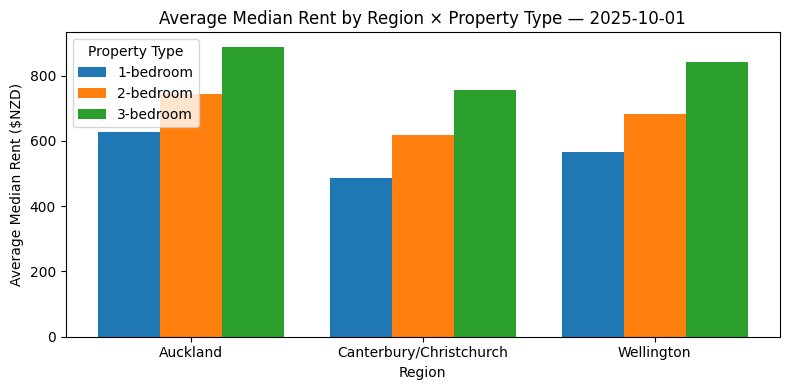

In [ ]:
# --- Latest month: Region × Property Type (clustered bars) -----------------
# Purpose: compare regions by property type for the most recent month.

Q_LATEST_RxPT = """
WITH latest AS (
  SELECT MAX(t.date_month) AS max_month
  FROM dim_time t
  JOIN fact_rent f ON f.time_id = t.time_id
)
SELECT
  d.region,
  pt.property_type_name,
  t.date_month,
  ROUND(AVG(f.median_rent), 2) AS avg_median_rent
FROM fact_rent f
JOIN dim_time t ON f.time_id = t.time_id
JOIN dim_suburb d ON f.suburb_id = d.suburb_id
JOIN dim_property_type pt ON f.property_type_id = pt.property_type_id
JOIN latest l ON t.date_month = l.max_month
GROUP BY d.region, pt.property_type_name, t.date_month
ORDER BY d.region, pt.property_type_name;
"""
df_rxpt = pd.read_sql(Q_LATEST_RxPT, engine, parse_dates=["date_month"])

if df_rxpt.empty:
    print("No data found for the latest month.")
else:
    # Prepare clustered bars: x-axis = regions, each property type = one bar per region group
    regions = sorted(df_rxpt["region"].unique().tolist())
    types = sorted(df_rxpt["property_type_name"].unique().tolist())

    # Build matrix (rows = types, cols = regions)
    mat = np.zeros((len(types), len(regions)))
    for i, tname in enumerate(types):
        for j, rname in enumerate(regions):
            val = df_rxpt.loc[
                (df_rxpt["property_type_name"] == tname) & (df_rxpt["region"] == rname),
                "avg_median_rent"
            ]
            mat[i, j] = float(val.iloc[0]) if not val.empty else np.nan

    x = np.arange(len(regions))
    width = 0.8 / max(1, len(types))  # total width split across types

    plt.figure(figsize=(8, 4))
    for i, tname in enumerate(types):
        plt.bar(x + i*width, mat[i], width=width, label=tname)

    latest_month = df_rxpt["date_month"].max().date()
    plt.title(f"Average Median Rent by Region × Property Type — {latest_month}")
    plt.xlabel("Region")
    plt.ylabel("Average Median Rent ($NZD)")
    plt.xticks(x + (len(types)-1)*width/2, regions)
    plt.legend(title="Property Type")
    plt.tight_layout()
    plt.savefig(FIG_DIR / "latest_region_property_type.png", dpi=120)
    plt.show()


In [68]:
# --- Cell 9: Dispose engine -----------------------------------------------
# Purpose: tidy up DB connections when running the notebook end-to-end.

engine.dispose()
print("Engine disposed.")


Engine disposed.
